In [1]:
! which python

/Users/no_lineal/opt/anaconda3/envs/grid38/bin/python


In [2]:
import numpy as np

from scipy.ndimage import maximum_filter
from scipy.signal import find_peaks

from tqdm import tqdm

import os

# viz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
"""

    where am i?

"""

PATH = os.getcwd()
precomputed_path = PATH + '/precomputed/'

print( f'PATH: { PATH }' )
print( f'precomputed path: { precomputed_path }' )

PATH: /Users/no_lineal/Documents/GitHub/dm-grid-cells
precomputed path: /Users/no_lineal/Documents/GitHub/dm-grid-cells/precomputed/


In [4]:
""" 

    load dataset

"""

res = np.load( precomputed_path + 'res/' + 'res_998.npy', allow_pickle=True, encoding='latin1' )
res = dict( res.item() )
scores = np.load( precomputed_path + 'scores/' + 'scores_998.npy', allow_pickle=True, encoding='latin1' )
scores = dict( scores.item() )

max_60_mask = np.load( precomputed_path + 'max_60_mask_55.npy', allow_pickle=True, encoding='latin1' )
max_90_mask = np.load( precomputed_path + 'max_90_mask_55.npy', allow_pickle=True, encoding='latin1' )
sac = np.load( precomputed_path + 'sac_55.npy', allow_pickle=True, encoding='latin1' )
score_60 = np.load( precomputed_path + 'score_60_55.npy', allow_pickle=True, encoding='latin1' )
score_90 = np.load( precomputed_path + 'score_90_55.npy', allow_pickle=True, encoding='latin1' )

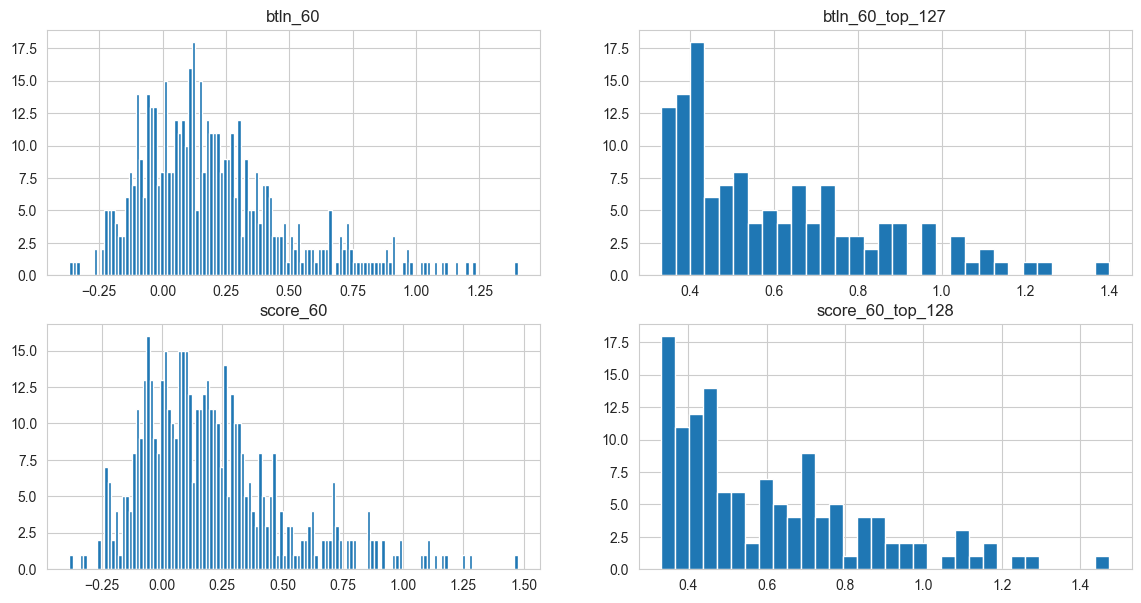

In [5]:
"""

    frozen score

"""

th = 0.33

btln_60 = scores[ 'btln_60' ]

btln_60_top_idx = np.where( btln_60 >= th )[0]
btln_60_top = btln_60[ btln_60_top_idx ]

score_60_top_idx = np.where( score_60 >= th )[0]
score_60_top = score_60[ score_60_top_idx ]

fig, axs = plt.subplots( 2 , 2, figsize=( 14, 7 ) )

axs[ 0, 0 ].hist( btln_60, bins=int((btln_60.shape[0])/4) )
axs[ 0, 0 ].set_title( 'btln_60' )

axs[ 0, 1 ].hist( btln_60_top, bins=int((btln_60_top.shape[0])/4) )
axs[ 0, 1 ].set_title( 'btln_60_top_' + str( len(btln_60_top) ) )

axs[ 1, 0 ].hist( score_60, bins=int((score_60.shape[0])/4) )
axs[ 1, 0 ].set_title( 'score_60' )

axs[ 1, 1 ].hist( score_60_top, bins=int((score_60_top.shape[0])/4) )
axs[ 1, 1 ].set_title( 'score_60_top_' + str( len(score_60_top) ) )

plt.show()

In [6]:
"""

    peak filter

"""

def peak_filter( sac, hc_center=True, footprint=(50, 50) ):

    global_max = []
    local_max = []
    distances = []
    
    for s in tqdm(sac):

        if hc_center:

            center = s.shape[0] // 2
            global_max_pos = ( center, center )

        else:

            global_max_pos = np.unravel_index( s.argmax(), s.shape )

        local_max_pos = maximum_filter(s, footprint=np.ones( footprint ), mode='wrap')
        dists = [ np.linalg.norm( np.array( global_max_pos ) - np.array( pos ) ) for pos in np.argwhere( local_max_pos == s ) ]

        global_max.append( global_max_pos )
        local_max.append( local_max_pos )
        distances.append( dists )

    return global_max, local_max, distances
        

sac = np.array( sac )
global_max, local_max, dists = peak_filter( sac, footprint=( 13, 13 ) )

print( f'sac: { sac.shape }' )
print( f'global_max: { len(global_max) }' )
print( f'local_max: { len(local_max) }' )
print( f'dists: { len(dists) }' )

100%|██████████| 512/512 [00:00<00:00, 2960.05it/s]

sac: (512, 109, 109)
global_max: 512
local_max: 512
dists: 512


idx_top_k: [509, 418, 152, 18, 248, 315, 361, 201, 174, 476]


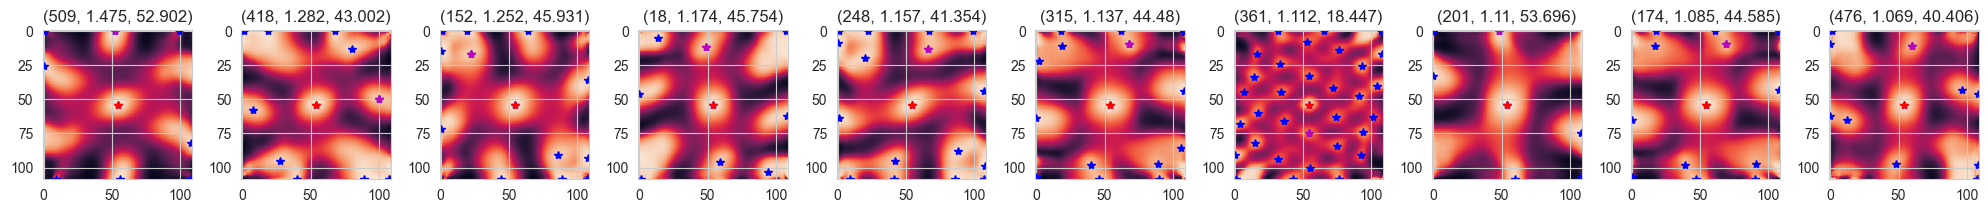

In [7]:
"""  

    viz top k

"""

def sort_max_score( score ):

    idxs = np.flip( np.argsort( score ) )

    return idxs

k = 10

score_idx = sort_max_score( score_60 )
score_top_idx = list(score_idx[:k])
#score_top_idx = np.random.choice( score_idx, size=k, replace=False )

sac_sample = sac[ score_top_idx ]
score_60_sample = score_60[ score_top_idx ]
global_sample = np.array(global_max)[ score_top_idx ]
local_sample = np.array(local_max)[ score_top_idx ]
local_sample = [ np.argwhere( local_sample[i] == sac_sample[i] ) for i in range(k) ]
dists_sample = [ dists[ idx ] for idx in score_top_idx ]

print( f'idx_top_k: { score_top_idx }' )

fig, axs = plt.subplots( 1 , k, figsize=( 20, 10 ) )

for i in range( k ):

    ad = dists_sample[i]
    al = local_sample[i]    

    ad = np.argsort( ad )[1]
    al = al[ ad ]

    axs[ i ].imshow( sac_sample[ i ] )
    axs[ i ].plot( local_sample[ i ][:,1], local_sample[ i ][:,0], 'b*' )
    axs[ i ].plot( global_sample[ i ][1], global_sample[ i ][0], 'r*' )
    axs[ i ].plot( al[1], al[0], 'm*' )
    axs[ i ].set_title( f'{  score_top_idx[i], round( score_60_sample[i], 3 ), round(np.mean( np.sort(dists_sample[i] )[:7]), 3) }' )

plt.tight_layout()
plt.show()

dist top: 128

[ 27  65 182]
[0.41717375 0.58585487 1.10521516]

[ 27  65 182]
[39, 92, 172]
[0.47044147 0.70570725 1.0608254 ]

[ 27  65 182]
[41, 98, 182]
[0.47931943 0.73234111 1.10521516]


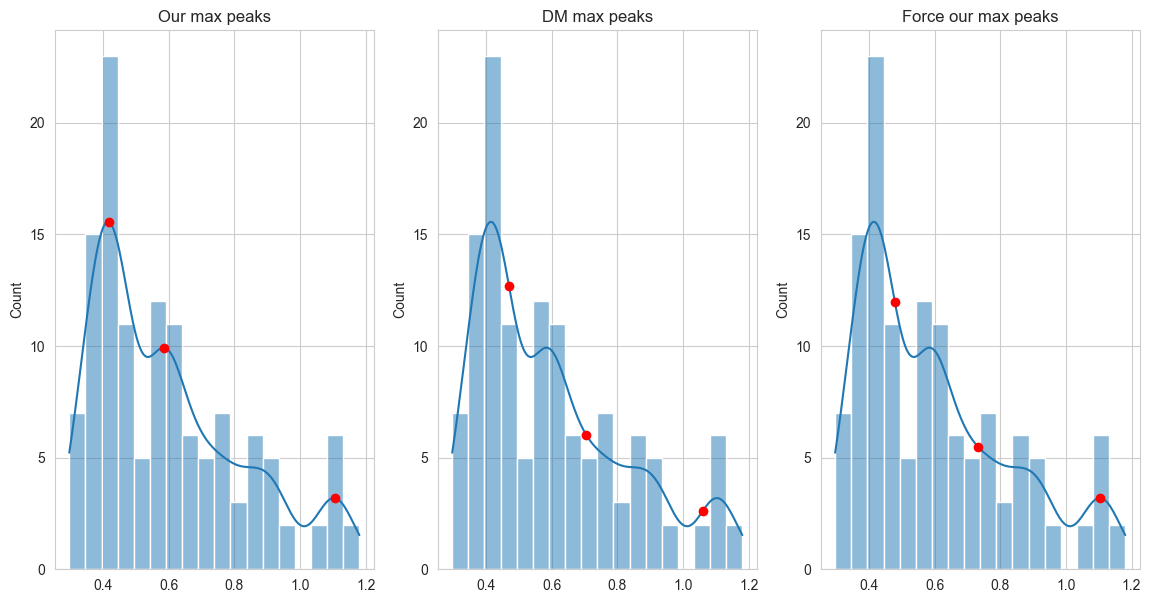

In [8]:
dists_top = [ (np.array(dists[idx]) * 2)/100 for idx in score_60_top_idx ]

print( f'dist top: { len( dists_top ) }' )
print('')

dists_top_min = [ np.min( x[ np.nonzero(x)[0] ] ) for x in dists_top ]
dists_top_mean = [ np.mean(np.sort(x[ np.nonzero(x)[0] ])[:2]) for x in dists_top ]

fig, axs = plt.subplots( 1 , 3, figsize=( 14, 7 ) )


hist = sns.histplot(dists_top_min, bins=int(len(dists_top) / 7), kde=True, kde_kws={'bw_adjust': 0.6}, ax=axs[0])

peaks, _ = find_peaks( hist.get_lines()[0].get_data()[1] )
print( peaks )
print( hist.get_lines()[0].get_data()[0][peaks] )

hist.plot( hist.get_lines()[0].get_data()[0][peaks], hist.get_lines()[0].get_data()[1][peaks], "ro" )

axs[ 0 ].set_title( 'Our max peaks' )

print( '' )

hist = sns.histplot(dists_top_mean, bins=int(len(dists_top) / 7), kde=True, kde_kws={'bw_adjust': 0.6}, ax=axs[1])

peaks, _ = find_peaks( hist.get_lines()[0].get_data()[1] )
print( peaks )
peaks = [ 39, 92, 172 ]
print( peaks )
print( hist.get_lines()[0].get_data()[0][peaks] ) 

hist.plot( hist.get_lines()[0].get_data()[0][peaks], hist.get_lines()[0].get_data()[1][peaks], "ro" )

axs[ 1 ].set_title( 'DM max peaks' )

print( '' )

hist = sns.histplot(dists_top_mean, bins=int(len(dists_top) / 7), kde=True, kde_kws={'bw_adjust': 0.6}, ax=axs[2])

peaks, _ = find_peaks( hist.get_lines()[0].get_data()[1] )
print( peaks )
peaks = [ 41, 98, 182 ]
print( peaks )
print( hist.get_lines()[0].get_data()[0][peaks] ) 

hist.plot( hist.get_lines()[0].get_data()[0][peaks], hist.get_lines()[0].get_data()[1][peaks], "ro" )

axs[ 2 ].set_title( 'Force our max peaks' )

plt.show()